Author: Riccardo Cappuzzo

In this notebook I will be looking into the tables included in the 
[Gittables repository](https://gittables.github.io). 

More detail (not much more) can be found in the [Usage page](https://gittables.github.io/usage.html).

In [1]:
import os
import os.path as osp
import pandas as pd
from pyarrow import parquet as pq
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import vaex

In [2]:
cd ~/work/study-gittables

/home/soda/rcappuzz/work/study-gittables


Printing info on all archives in the folder.

In [3]:
data_folder = "data/zenodo/"
archives_folder = osp.join(data_folder, "archives")
tables_folder = osp.join(data_folder, "tables")
info_tables_folder = osp.join(data_folder, "info_tables")


In [4]:
for filename in sorted(os.listdir(archives_folder)[:10]):
    fpath = osp.join(archives_folder, filename)
    file_size = osp.getsize(fpath)
    print(f"{filename:.<80}{file_size/1024:.>10.0f}KB")


abstraction_tables_licensed.zip.....................................................179234KB
allegro_con_spirito_tables_licensed.zip...............................................3269KB
attrition_rate_tables_licensed.zip....................................................3915KB
beats_per_minute_tables_licensed.zip.................................................11270KB
beauty_sleep_tables_licensed.zip.....................................................27162KB
bits_per_second_tables_licensed.zip..................................................81960KB
cardiac_output_tables_licensed.zip....................................................4945KB
cease_tables_licensed.zip............................................................24603KB
centripetal_acceleration_tables_licensed.zip..........................................6498KB
channel_capacity_tables_licensed.zip.................................................27547KB


All the archives were extracted in their respective subfolders in `data/zenodo/tables`. 

## Aggregate study of the tables

I'll be relying a lot on Pandas' functions to infer types and extract metrics. I don't know how well this will go. 

Note: I moved the code for gathering stats on the content of a folder to `stat_tables.py`. 

### Putting together everything
After running `stat_tables.py` (this took around one hour or so, after using joblib to parallelize some of the operations),
I now have a very long list of csv files that contain statistics about the tables.
The statistics I have gathered are the following: 

```py
statistics = ['group_name', # The name of the parent folder
        'name', # The name of the scraped dataset 
        'tot_rows', # The number of rows in the dataset
        'tot_columns', # The number of columns in the dataset 
        'tot_values', # tot_rows*tot_columns
        'num_columns', # number of numerical columns (as inferred by pandas)
        'cat_columns', # number of categorical columns (as inferred by pandas)
        'uniq_cat_values', # number of unique categorical values 
        'avg_red_cat_values' # average redundancy of the unique cat values
]
```

I combine the datasets using a shell command. 

In [5]:
# ! tail -n +2 -q *.csv > info_compiled.csv

## Reading the compiled information file

In [6]:
statistics = ['group_name', # The name of the parent folder
        'name', # The name of the scraped dataset 
        'tot_rows', # The number of rows in the dataset
        'tot_columns', # The number of columns in the dataset 
        'tot_values', # tot_rows*tot_columns
        'num_columns', # number of numerical columns (as inferred by pandas)
        'cat_columns', # number of categorical columns (as inferred by pandas)
        'uniq_cat_values', # uni
        'avg_red_cat_values'
]

info_file_name = "info_compiled.csv"
info_file_path = osp.join(info_tables_folder, info_file_name)
_df = pd.read_csv(info_file_path, header=None)
_df.columns = statistics + ['index']
_df = _df.drop(['index'], axis=1)

<AxesSubplot: xlabel='tot_rows', ylabel='Count'>

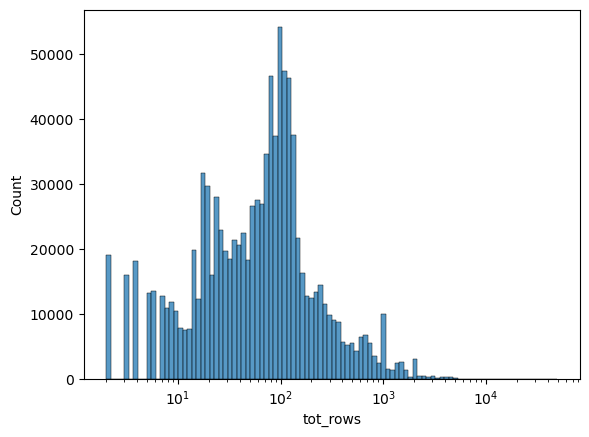

In [7]:
sns.histplot(data=_df, x="tot_rows", log_scale=True, bins=100)

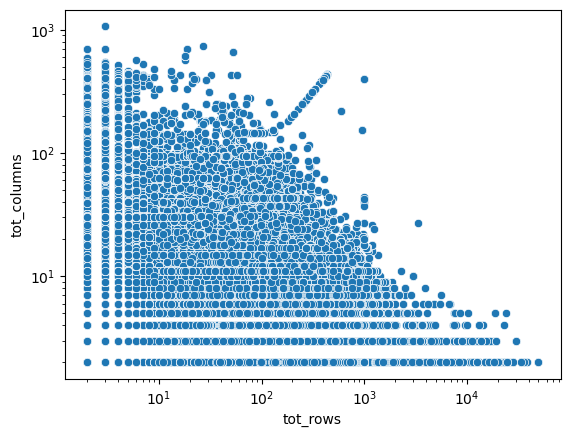

In [8]:
ax = sns.scatterplot(data=_df, x='tot_rows', y='tot_columns')
ax.set_xscale('log')
ax.set_yscale('log')

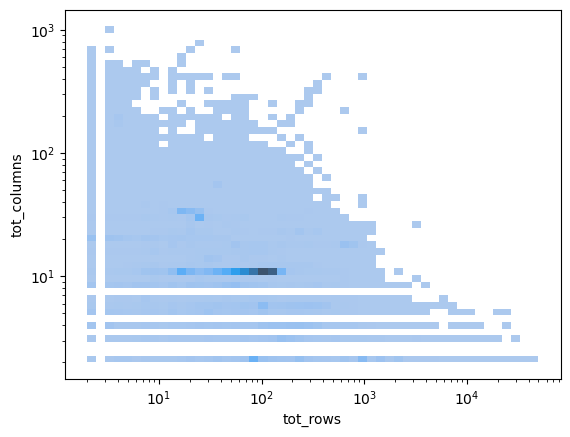

In [9]:
ax = sns.histplot(data=_df, bins=(50,50), x='tot_rows', y='tot_columns', log_scale = (True, True))

# ax.set_xscale('log')
# ax.set_yscale('log')

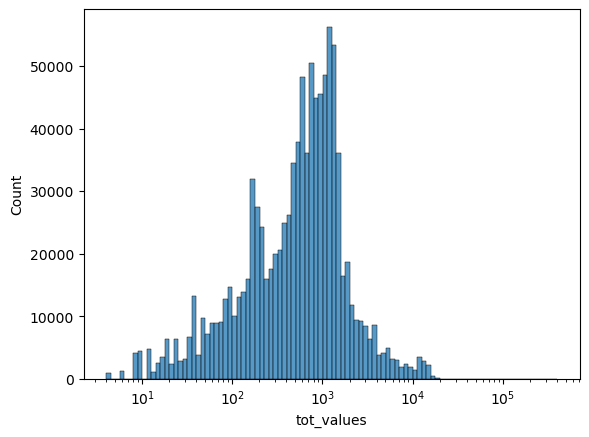

In [11]:
ax = sns.histplot(data=_df, x='tot_values', bins=100, log_scale=(True, False))

In [16]:
print(f"80% quantile of tot_rows is {np.quantile(_df['tot_rows'], .8)}")
print(f"80% quantile of tot_values is  {np.quantile(_df['tot_values'], .8)}")

80% quantile of tot_rows is 140.0
80% quantile of tot_values is  1298.0


In [35]:
def stats_on_var(df, var_name):
    col = f"tot_{var_name}"
    
    
    print(f"Statistics on {var_name}")
    print(f"{'Median:':<10} {_df[col].median():>10.1f}")
    print(f"{'Mean:':<10} {_df[col].mean():>10.1f}")    
    print(f"{'Max:':<10} {_df[col].max():>10.1f}")    
    print(f"{'Min:':<10} {_df[col].min():>10.1f}")    
    print(f"{'qle 80:':<10} {_df[col].quantile(.8):>10.1f}")    
    
    

In [36]:
stats_on_var(_df, 'rows')
stats_on_var(_df, 'columns')
stats_on_var(_df, 'values')

Statistics on rows
Median:          68.0
Mean:           141.3
Max:          49515.0
Min:              2.0
qle 80:         140.0
Statistics on columns
Median:          11.0
Mean:            12.1
Max:           1068.0
Min:              2.0
qle 80:          12.0
Statistics on values
Median:         608.0
Mean:          1035.7
Max:         401802.0
Min:              4.0
qle 80:        1298.0
